In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from cp_hw2 import *
from tqdm import tqdm

In [4]:
video_file = "data/drive-download-20241101T180510Z-001/DSC_0510.MOV"
cap = cv2.VideoCapture(video_file)
frames = []
frame_num = 0
frame_skip_count = 15
pixel_skip_count = 2
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num = frame_num + 1
    if frame_num % frame_skip_count == 0:
        frames.append(frame[::pixel_skip_count, ::pixel_skip_count, ::-1])
cap.release()
frames = np.array(frames).transpose(1, 2, 3, 0)

def Linearize(I_nonlinear):
    return np.where(I_nonlinear <= 0.0404482, I_nonlinear / 12.92, ((I_nonlinear + 0.055) / 1.055) ** 2.4)

def luminance(image):
    if(len(image.shape) == 3):
        image = np.expand_dims(image, axis=3)
    img_linear = Linearize(image)
    img_XYZ = np.zeros(img_linear.shape)
    for frame in range(img_XYZ.shape[-1]):
        img_XYZ[:,:,:,frame] = lRGB2XYZ(img_linear[:,:,:,frame])
    return img_XYZ[:,:,1,:]


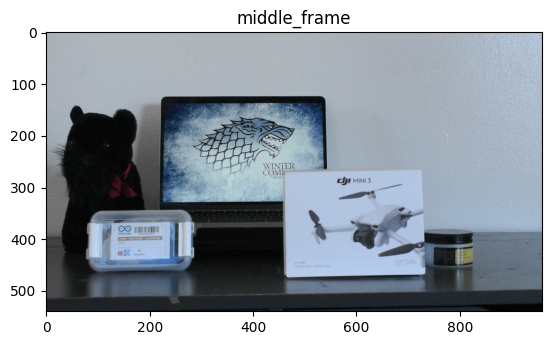

In [16]:
# def get_pixel_coords(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print(f"Coordinates of selected pixel: x={y}, y={x}")
#         return (x,y)

# cv2.namedWindow('Image')
# cv2.setMouseCallback('Image', get_pixel_coords)

middle_frame = frames[:,:,:,frames.shape[3] // 2]
plt.imshow(middle_frame)
plt.title('middle_frame')
plt.show()
# while True:
#     cv2.imshow('Image', middle_frame)
#     if cv2.waitKey(1) & 0xFF == 27:  
#         break

# cv2.destroyAllWindows()



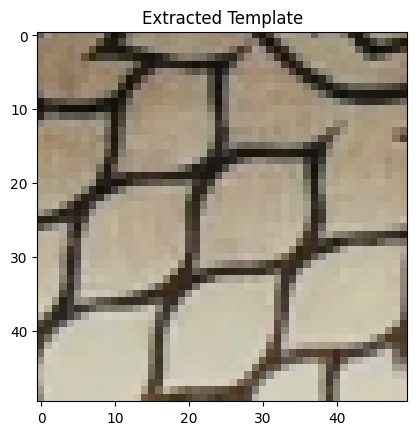

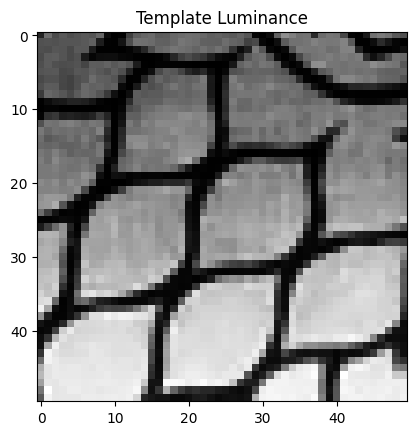

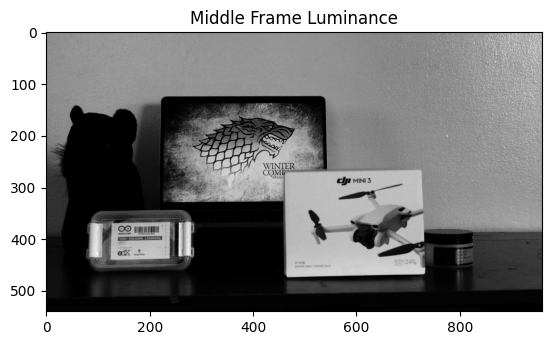

Template luminance shape: (50, 50, 1)
Middle frame luminance shape: (540, 960, 1)


In [17]:
#Laptop Screen:
# Coordinates of selected pixel: x=191, y=346

# Tiny ML Box:
# Coordinates of selected pixel: x=382, y=145

# DJI:
# Coordinates of selected pixel: x=283, y=564

# COSRX:
# Coordinates of selected pixel: x=410, y=772

middle_frame_index = frames.shape[3] // 2
middle_frame = frames[:, :, ::-1, middle_frame_index]

start_point = (191, 346)
rect_width, rect_height = 50, 50

frame_with_rectangle = cv2.rectangle(
    middle_frame.copy(),
    start_point,
    (start_point[0] + rect_width, start_point[1] + rect_height),
    color=(255, 0, 0),
    thickness=2
)

cv2.imshow("Middle Frame with Rectangle", frame_with_rectangle)
cv2.waitKey(5)
cv2.destroyAllWindows()

x_start, y_start = start_point
x_end = x_start + rect_height
y_end = y_start + rect_width
bounding_box = (x_start, y_start, x_end, y_end)
template_image = middle_frame[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

plt.imshow(template_image)
plt.title('Extracted Template')
plt.show()

template_luminance = luminance(template_image)
middle_frame_luminance = luminance(middle_frame)

plt.imshow(template_luminance, cmap='gray')
plt.title('Template Luminance')
plt.show()

plt.imshow(middle_frame_luminance, cmap='gray')
plt.title('Middle Frame Luminance')
plt.show()

print("Template luminance shape:", template_luminance.shape)
print("Middle frame luminance shape:", middle_frame_luminance.shape)


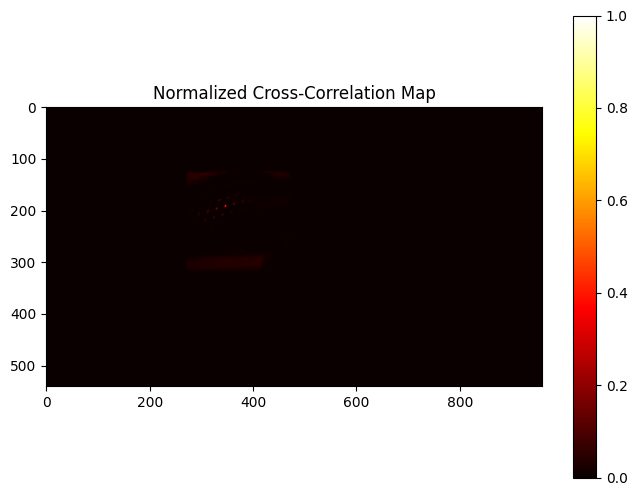

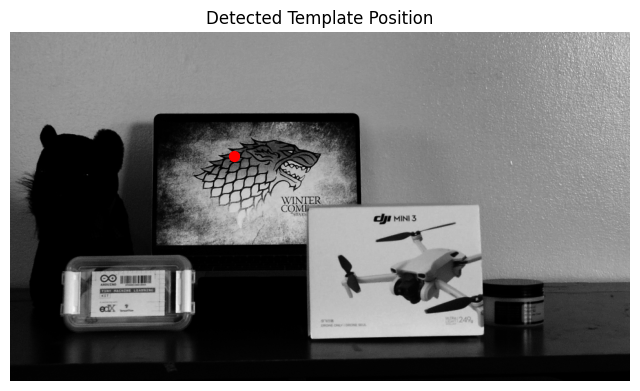

Shift: (0, 0)


In [18]:
def normalized_cross_correlation(image, template, bounding_box):
    template_mean = template.mean()
    template_variance = np.sum((template - template_mean) ** 2)
    ncc_map = np.zeros(image.shape)

    bbox_top, bbox_left, bbox_bottom, bbox_right = bounding_box
    bbox_center_y = (bbox_top + bbox_bottom) / 2
    bbox_center_x = (bbox_left + bbox_right) / 2
    search_radius_y, search_radius_x = np.array(template.shape) * 2

    for y in range(image.shape[0]):
        if abs(y - bbox_center_y) > search_radius_y:
            continue
        for x in range(image.shape[1]):
            if abs(x - bbox_center_x) > search_radius_x:
                continue
            if (y + template.shape[0] > image.shape[0]) or (x + template.shape[1] > image.shape[1]):
                continue
            roi = image[y:y + template.shape[0], x:x + template.shape[1]]
            if roi.shape != template.shape:
                continue
            roi_mean = roi.mean()
            roi_variance = np.sum((roi - roi_mean) ** 2)
            numerator = np.sum((roi - roi_mean) * (template - template_mean))
            denominator = np.sqrt(template_variance * roi_variance)
            if denominator != 0:
                ncc_map[y, x] = numerator / denominator
            else:
                ncc_map[y, x] = 0
    return ncc_map

def calculate_shift(ncc_map, bounding_box):
    peak_y, peak_x = np.unravel_index(np.argmax(ncc_map), ncc_map.shape)
    shift_x = peak_x - bounding_box[1]  
    shift_y = peak_y - bounding_box[0]  
    return shift_x, shift_y

def display_correspondence(ncc_map, frame=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(ncc_map ** 4, cmap='hot')
    plt.title('Normalized Cross-Correlation Map')
    plt.colorbar()
    plt.show()

    if frame is not None:
        peak_y, peak_x = np.unravel_index(np.argmax(ncc_map), ncc_map.shape)
        plt.figure(figsize=(8, 6))
        plt.imshow(frame, cmap='gray')
        plt.scatter(peak_x, peak_y, s=50, c='red', marker='o')
        plt.title('Detected Template Position')
        plt.axis('off')
        plt.show()

ncc_map = normalized_cross_correlation(middle_frame_luminance[:, :, 0], template_luminance[:, :, 0], bounding_box)

display_correspondence(ncc_map, middle_frame_luminance[:, :, 0])

shift_x, shift_y = calculate_shift(ncc_map, bounding_box)
print('Shift:', (shift_x, shift_y))


/var/folders/8w/xlcv5msx3nsg3_r1dw3tj1500000gn/T/ipykernel_33232/2000768055.py:5: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(
  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/8w/xlcv5msx3nsg3_r1dw3tj1500000gn/T/ipykernel_33232/2000768055.py:29: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regul

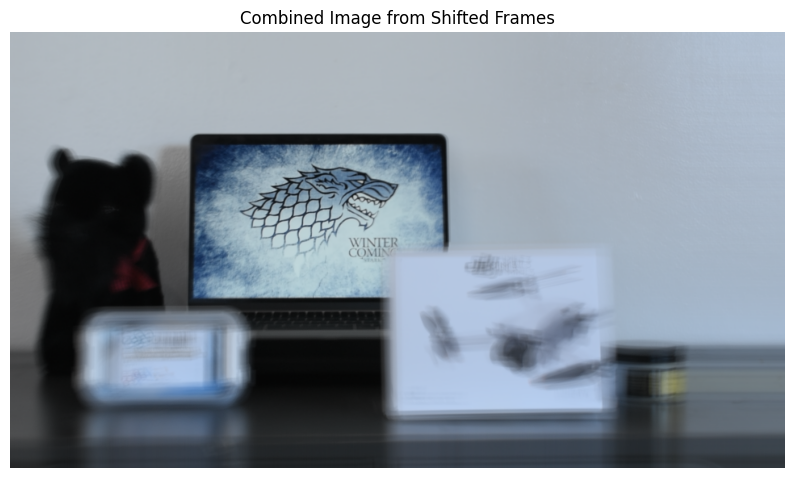

In [20]:

interpolators = []
for frame_index in range(frames.shape[3]):
    frame_interpolators = []
    for channel in range(3):  
        interp_func = interp2d(
            x=np.arange(frames.shape[1]),  
            y=np.arange(frames.shape[0]),  
            z=frames[:, :, channel, frame_index],
            kind='linear'
        )
        frame_interpolators.append(interp_func)
    interpolators.append(frame_interpolators)

shifted_frames = np.zeros_like(frames, dtype=np.float64)  
shift_list = []
frames_luminance = luminance(frames)
combined_frame = np.zeros(frames[:, :, :, 0].shape, dtype=np.float64)  

for idx in tqdm(range(frames.shape[3])):
    ncc_map = normalized_cross_correlation(frames_luminance[:, :, idx], template_luminance[:, :, 0], bounding_box)
    shift_x, shift_y = calculate_shift(ncc_map, bounding_box)
    shift_list.append((shift_x, shift_y))

    shifted_frame = np.zeros(frames[:, :, :, 0].shape, dtype=np.float64)
    current_interpolators = interpolators[idx]
    x_coords = np.arange(frames.shape[1]) + shift_x
    y_coords = np.arange(frames.shape[0]) + shift_y
    for channel in range(3):
        shifted_frame[:, :, channel] = current_interpolators[channel](x_coords, y_coords)
    shifted_frames[:, :, :, idx] = shifted_frame.copy()

    combined_frame += shifted_frame / frames.shape[3]

# Display the combined image
plt.figure(figsize=(10, 8))
plt.imshow(np.clip(combined_frame.astype('uint8'), 0, 255))  
plt.title('Combined Image from Shifted Frames')
plt.axis('off')
plt.show()
